# A notebook with a simple Solow model 
You ca run each cell by pressing the run tool or shift+enter

# Import Python libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pylab  as plt 
import seaborn as sns
#import qgrid

import sys
sys.path.append('modelflow/')

from modelsandbox import newmodel  
from modelsandbox import newton_diff
from modelmanipulation import explode  
from modeljupyter import inputwidget

ModelFlow info: CVXopt not installed. Only matters if you are incorporating optimization


# Specify the model 
The explode function will rewrite the business logic.

In [2]:
fsolow = explode('''\
Y         = a * k**alfa * l **(1-alfa) 
C         = (1-SAVING_RATIO)  * Y 
I         = Y - C 
diff(K)   = I-depreciates_rate * K(-1)
diff(l)   = labor_growth * L(-1) 
K_intense = K/L 
''')
print(fsolow)

FRML <> Y         = A * K**ALFA * L **(1-ALFA)  $
FRML <> C         = (1-SAVING_RATIO)  * Y  $
FRML <> I         = Y - C  $
FRML <> K=K(-1)+(I-DEPRECIATES_RATE * K(-1))$
FRML <> L=L(-1)+(LABOR_GROWTH * L(-1))$
FRML <> K_INTENSE = K/L  $


# Create a model class instance

In [3]:
msolow = newmodel(fsolow)

This model has simultaneous elements or cyclical elements.


# Show model structure

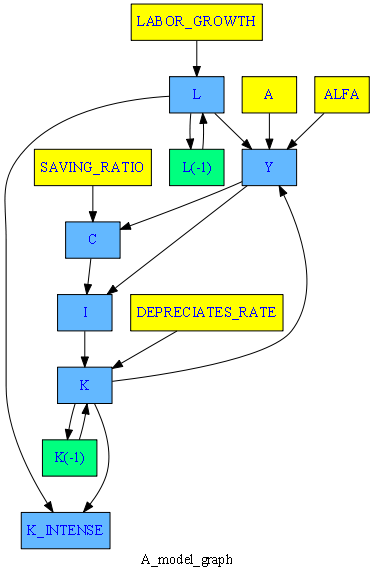

In [4]:
msolow.drawmodel(sink = 'K_INTENSE')

# Show solving structure (only current year)

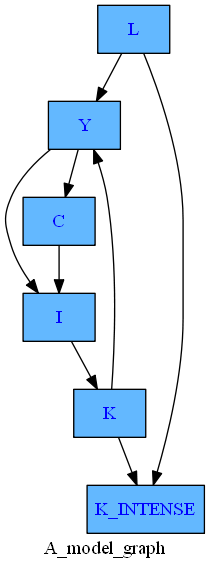

In [5]:
msolow.drawendo(sink = 'K_INTENSE',source='L')

# Create DataFrame with baseline exogenous 

In [6]:
N = 300
df = pd.DataFrame({'L':[100]*N,'K':[100]*N})
df.loc[:,'ALFA'] = 0.5
df.loc[:,'A'] = 1.
df.loc[:,'DEPRECIATES_RATE'] = 0.05
df.loc[:,'LABOR_GROWTH'] = 0.01
df.loc[:,'SAVING_RATIO'] = 0.05
display(df.head())

L    K  ALFA    A  DEPRECIATES_RATE  LABOR_GROWTH  SAVING_RATIO
0  100  100   0.5  1.0              0.05          0.01          0.05
1  100  100   0.5  1.0              0.05          0.01          0.05
2  100  100   0.5  1.0              0.05          0.01          0.05
3  100  100   0.5  1.0              0.05          0.01          0.05
4  100  100   0.5  1.0              0.05          0.01          0.05

# Run Baseline

In [7]:
res1 = msolow(df,antal=100,first_test=10,silent=1,ljit=True)
display(res1.head())

Generating source for testmodel using ljit = True 
make model text started at :        14:28:34 
make model text took       :    0.0000000000 Seconds
Compiling chunk 1/1      14:28:34
Compiling a mastersolver      14:28:35
Compiling chunk 1/1      14:28:35
Compiling a mastersolver      14:28:35
Compiling chunk 1/1      14:28:35
Compiling a mastersolver      14:28:36


L           K  ALFA    A  DEPRECIATES_RATE  LABOR_GROWTH  \
0  100.000000  100.000000   0.5  1.0              0.05          0.01   
1  101.000000  100.025580   0.5  1.0              0.05          0.01   
2  102.010000  100.076226   0.5  1.0              0.05          0.01   
3  103.030100  100.151443   0.5  1.0              0.05          0.01   
4  104.060401  100.250762   0.5  1.0              0.05          0.01   

   SAVING_RATIO           Y          C         I  K_INTENSE  
0          0.05    0.000000   0.000000  0.000000   0.000000  
1          0.05  100.511609  95.486029  5.025580   0.990352  
2          0.05  101.038487  95.986562  5.051924   0.981043  
3          0.05  101.580575  96.501546  5.079029   0.972060  
4          0.05  102.137821  97.030930  5.106891   0.963390

In [8]:
msolow.current_per


RangeIndex(start=1, stop=300, step=1)

# Create interactive widgets 
If you are not familiar with Python and Ipywidgets, don't try to understand the code. 
Just notice that it is fairly short. 

In [9]:
vtrans = {}

slidedef =      {'Productivity'     : {'var':'ALFA',             'value': 0.5 ,'min':0.0, 'max':1.0},
                 'DEPRECIATES_RATE' : {'var':'DEPRECIATES_RATE', 'value': 0.05,'min':0.0, 'max':1.0}, 
                 'LABOR_GROWTH'     : {'var':'LABOR_GROWTH',     'value': 0.01,'min':0.0, 'max':1.0},
                 'SAVING_RATIO'     : {'var': 'SAVING_RATIO',    'value': 0.05,'min':0.0, 'max':1.0}
                        }       

input = inputwidget(msolow,res1,slidedef=slidedef
                   ,showout=True,varpat='Y C I K L K_INTENSE',modelopt={'silent':True,'start':1,'slut':300,},trans=vtrans)

# Run interactive widget 

In [10]:
display(input)      

In [11]:
msolow.y.explain(up=4,svg=1,dec=4);

# Finding derivatives (for Newton solver)

## Symbolic

In [12]:
newton    = newton_diff(msolow)
diff_model = newton.get_diffmodel()
print(diff_model.equations)

 Initialize 0
FRML  <> C__p__Y__lag__0 = -SAVING_RATIO + 1   $
FRML  <> I__p__C__lag__0 = -1   $
FRML  <> I__p__Y__lag__0 = 1   $
FRML  <> K__p__I__lag__0 = 1   $
FRML  <> K__p__K__lag__1 = -DEPRECIATES_RATE + 1   $
FRML  <> K_INTENSE__p__K__lag__0 = 1/L   $
FRML  <> K_INTENSE__p__L__lag__0 = -K/L**2   $
FRML  <> L__p__L__lag__1 = LABOR_GROWTH + 1   $
FRML  <> Y__p__K__lag__0 = A*ALFA*K**ALFA*L**(-ALFA + 1)/K   $
FRML  <> Y__p__L__lag__0 = A*K**ALFA*L**(-ALFA + 1)*(-ALFA + 1)/L   $


## Numerical 

In [13]:
newtonnum = newton_diff(msolow,forcenum=1)
diff_model = newtonnum.get_diffmodel()
print(diff_model.equations)

 Initialize 0
FRML  <> C__p__Y__lag__0 = (((1-SAVING_RATIO)*(Y+0.0025))-((1-SAVING_RATIO)*(Y-0.0025)))/0.005   $
FRML  <> I__p__C__lag__0 = ((Y-(C+0.0025))-(Y-(C-0.0025)))/0.005   $
FRML  <> I__p__Y__lag__0 = (((Y+0.0025)-C)-((Y-0.0025)-C))/0.005   $
FRML  <> K__p__I__lag__0 = ((K(-1)+((I+0.0025)-DEPRECIATES_RATE*K(-1)))-(K(-1)+((I-0.0025)-DEPRECIATES_RATE*K(-1))))/0.005   $
FRML  <> K__p__K__lag__1 = (((K(-1)+0.0025)+(I-DEPRECIATES_RATE*(K(-1)+0.0025)))-((K(-1)-0.0025)+(I-DEPRECIATES_RATE*(K(-1)-0.0025))))/0.005   $
FRML  <> K_INTENSE__p__K__lag__0 = (((K+0.0025)/L)-((K-0.0025)/L))/0.005   $
FRML  <> K_INTENSE__p__L__lag__0 = ((K/(L+0.0025))-(K/(L-0.0025)))/0.005   $
FRML  <> L__p__L__lag__1 = (((L(-1)+0.0025)+(LABOR_GROWTH*(L(-1)+0.0025)))-((L(-1)-0.0025)+(LABOR_GROWTH*(L(-1)-0.0025))))/0.005   $
FRML  <> Y__p__K__lag__0 = ((A*(K+0.0025)**ALFA*L**(1-ALFA))-(A*(K-0.0025)**ALFA*L**(1-ALFA)))/0.005   $
FRML  <> Y__p__L__lag__0 = ((A*K**ALFA*(L+0.0025)**(1-ALFA))-(A*K**ALFA*(L-0.0025)**(

In [14]:
pd.DataFrame(newton.get_diff_mat_1per()[3].toarray())

Generating source for  all lags and leads using ljit = 0 
make model text started at :        14:29:03 
make model text took       :    0.0010001659 Seconds


0    1         2    3         4     5
0 -1.0  0.0  0.000000  0.0  0.000000  0.95
1 -1.0 -1.0  0.000000  0.0  0.000000  1.00
2  0.0  1.0 -0.050000  0.0  0.000000  0.00
3  0.0  0.0  0.009706 -1.0 -0.009435  0.00
4  0.0  0.0  0.000000  0.0  0.010000  0.00
5  0.0  0.0  0.507135  0.0  0.492966 -1.00